In [1]:
import os
import sys
import numpy as np
import pandas as pd

IMATOOLS_DIR = os.getcwd()+'/..'
sys.path.insert(1, IMATOOLS_DIR)

from imatools.common import vtktools as vtku
from imatools.common import ioutils as iou

def calc_cog(pts, el):
    return [np.mean(pts[ee], 0) for ee in el]


def norm2(a): return np.linalg.norm(a)
def norm_vec(a): return a/norm2(a)


def remove_from_dirlist(dir_list, name_to_rm):
    if name_to_rm in dir_list:
        dir_list.remove(name_to_rm)

    return dir_list

def perc_above(arr, th) : 
    return np.sum(arr>th) / len(arr)

def perc_below(arr, th) : 
    return np.sum(arr<th) / len(arr)


# Locations of hard drive based on platform
dirdic = {'macOS': '/Volumes/sandisk',
          'Linux': '/media/jsl19/sandisk',
          'Windows': 'D:/'}

tex_dic = {'macOS': '/Users/jsolislemus/Documents/TEX',
           'Linux': '/home/jsl19/Documents/tex'}

base_dir = iou.fullfile(dirdic[iou.chooseplatform()], '01_atrialfibres/06_Reproducibility/05_UserProjects')
comp_dir = iou.fullfile(base_dir, '011_comparisons')

ld = remove_from_dirlist(os.listdir(iou.fullfile(comp_dir,'C0')), 'COMPARISONS')
ld = remove_from_dirlist(ld, 'MAPPING')

CX = ['C' + str(n) for n in np.linspace(0,49,num=50, dtype=int)]

print(ld)

['M1', 'M2']


# Preliminaries: 
+ Get comparison paths and create the `processing` and `mode` lists
+ Create local_cv files using the `gradlat` files 

In [2]:
df_comp = pd.read_csv(iou.fullfile(comp_dir, 'comparisons_path.csv'))
mode = df_comp['mode']
mode = mode[np.linspace(0,98,num=50, dtype=int)]

processing_raw = df_comp['processing'].tolist()
processing_raw = [processing_raw[ix] + processing_raw[ix+1] for ix in range(50)]

a='automatic'
m='manual'

processing = [p.replace(a+a, a) for p in processing_raw]
processing = [p.replace(m+m, m) for p in processing]
processing = [p.replace(a+m, 'mixed') for p in processing]
processing = [p.replace(m+a, 'mixed') for p in processing]

files_and_mapping = {
    'lat': ('LAT_RSPV_X.dat', 'fibre_X_pts.csv'),
    'cv': ('local_cv_X.dat', 'fibre_X_pts.csv'),
    'gradlat': ('lat_X.gradmag.dat', 'fibre_X_pts.csv'),
    'ps': ('PSNodeSmooth.dat', 'input_pts.csv'),
    'f_endo': ('fibre_X_endo.lon', 'fibre_X_endo_elem.csv'),
    'f_epi': ('fibre_X_epi.lon', 'fibre_X_epi_elem.csv')
}

print(len(mode))
print(len(processing))

50
50


Create comparison list

In [3]:
if iou.chooseplatform() == 'Linux':
    comparison_list = [c.replace('/Volumes', '/media/jsl19')
                       for c in df_comp['comparison_path'].tolist()]
else:
    comparison_list = df_comp['comparison_path'].tolist()
cx = 0  # go in even numbers!
import scipy.stats as sstat

def cname(dx, mx) : 
    return dx + '_' + mx + '.csv' 
comp_a = comparison_list[cx]
comp_b = comparison_list[cx+1]


## Create local cv
Create `local_cv_X.dat` files with the reciprocal of each `gradlat_X.dat`

In [4]:
dx = 'gradlat'
mmxx = ['1', 'l'] 

mx = mmxx[0]

for c in comparison_list : 
    for mx in mmxx : 
        fname = files_and_mapping[dx][0].replace('X', mx)
        gradlat = np.loadtxt(iou.fullfile(c, fname))
        qrts = iou.get_boxplot_values(gradlat)
        gradlat[gradlat < qrts['low_whisker']] = np.nan
        lcv = 1/gradlat
        
        np.savetxt(iou.fullfile(c, 'local_cv_' + mx + '.dat'), lcv)

iou.cout('Finished')

[INFO] Finished


In [93]:
cx = 0
dx = 'cv'
mx = 'l'

iou.fullfile(comparison_list[cx+1], files_and_mapping[dx][0].replace('X', mx))


'/media/jsl19/sandisk/01_atrialfibres/06_Reproducibility/05_UserProjects/011_comparisons/C0/M2/local_cv_l.dat'

{'min': 239.8305836756915, 'low_whisker': 239.8305836756915, 'low_quartile': 619.248727443865, 'median': 730.7163943530237, 'high_quartile': 876.3704242509223, 'high_whisker': 1262.0529694615082, 'max': 2344.94628900525}


<AxesSubplot:>

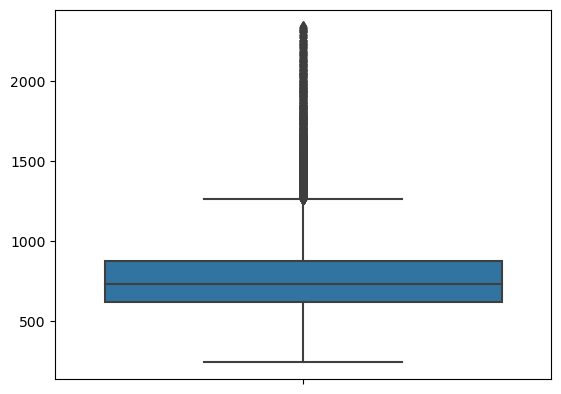

In [4]:
import seaborn as sns

dx = 'cv'
mx = 'l'

cx = 4
comp_a = iou.fullfile(comparison_list[cx], files_and_mapping[dx][0].replace('X', mx))
comp_b = iou.fullfile(comparison_list[cx+1], files_and_mapping[dx][0].replace('X', mx))

f_a = np.loadtxt(comp_a)
f_b = np.loadtxt(comp_b)

print(iou.get_boxplot_values(f_a))
sns.boxplot(y=f_a)


In [18]:
import scipy.stats as sstat

def cname(dx, mx) : 
    return dx + '_' + mx + '.csv' 

dx = 'lat'
mx = 'l'

cx = 0
comparison_file = iou.fullfile(comp_dir, CX[cx], 'COMPARISONS', cname(dx, mx))

df = pd.read_csv(comparison_file, skipinitialspace=True)



comp_a = iou.fullfile(comparison_list[cx], files_and_mapping[dx][0].replace('X', mx))
comp_b = iou.fullfile(comparison_list[cx+1], files_and_mapping[dx][0].replace('X', mx))

f_a = np.loadtxt(comp_a)
f_b = np.loadtxt(comp_b)

TAT = lambda x : np.nanmax(x) - np.nanmin(x)
print('A: {}, B: {}, diff : {}'.format(TAT(f_a), TAT(f_b), TAT(f_a)-TAT(f_b)))

print(np.corrcoef(df['lat_0'], df['lat_1']))

ss = sstat.pearsonr(df['lat_0'], df['lat_1'])

# ss.statistic
# sns.lmplot(data=df.sample(1000), x='lat_0', y='lat_1')

df

A: 143.6578, B: 137.4167, diff : 6.241100000000017
[[1.         0.96529684]
 [0.96529684 1.        ]]


,diff_square,diff_abs,lat_0,lat_1,distance
0,576.148810,24.0031,104.6860,80.6829,0.061969
1,588.702874,24.2632,104.5950,80.3318,0.190832
2,590.694138,24.3042,104.7080,80.4038,0.172751
3,583.029316,24.1460,104.7450,80.5990,0.114740
4,580.916045,24.1022,104.7820,80.6798,0.135512
...,...,...,...,...,...
262876,275.261281,16.5910,130.4290,113.8380,0.453934
262877,284.195536,16.8581,108.1070,91.2489,0.210283
262878,412.455481,20.3090,133.6850,113.3760,0.356253
262879,296.869454,17.2299,111.1130,93.8831,0.097240


### LAT Comparisons
1. Pairwise correlation coefficient (from mapping data)
2. Total activation time for each, then ranksum or ttest 

|     | Correlation | p-val | total activation (MX) | total activation (MY) | abs(diff) | mode  | processing |    fibre   |
|-----|-------------|-------|-----------------------|-----------------------|-----------|-------|------------|------------|
| C0  |             |       |                       |                       |           | inter | mixed      |      1     |
| C0  |             |       |                       |                       |           | inter | automatic  |      l     |
| C1  |             |       |                       |                       |           | inter | automatic  |      1     | 
| ... |             |       |                       |                       |           | ...   | ...        |     ...    |
| C49 |             |       |                       |                       |           | intra | manual     |      l     | 

In [5]:
def cname(dx, mx):
    return dx + '_' + mx + '.csv'


def TAT(x): return np.nanmax(x) - np.nanmin(x)


subsample = 1


In [6]:
import scipy.stats as sstat



dx = 'lat'
fibre_files = ['1', 'l']
keys = ['correlation', 'corr_p_val', 'tat_a', 'tat_b', 'abs_diff', 'mode', 'processing', 'fibre' ]
midic = dict.fromkeys(keys)

midic['correlation'] = np.zeros(len(CX)*2)
midic['corr_p_val'] = np.zeros(len(CX)*2)
midic['tat_a'] = np.zeros(len(CX)*2)
midic['tat_b'] = np.zeros(len(CX)*2)
midic['fibre'] = ['1', 'l']*50
midic['mode'] = df_comp['mode'].tolist()
midic['processing'] = np.repeat(processing,2)


for cx in range(len(CX)) : 
    for fx in range(len(fibre_files)) :
        
        comparison_file = iou.fullfile(comp_dir, CX[cx], 'COMPARISONS', cname(dx, fibre_files[fx]))
        df = pd.read_csv(comparison_file, skipinitialspace=True).sample(frac=subsample)
        A = df[dx+'_0']
        B = df[dx+'_1']
        ss = sstat.pearsonr(x=A, y=B)

        idx = 2*cx + fx 

        midic['correlation'][idx] = ss.statistic
        midic['corr_p_val'][idx] = ss.pvalue
        midic['tat_a'][idx] = TAT(A)
        midic['tat_b'][idx] = TAT(B)

midic['abs_diff'] = np.abs(midic['tat_a'] - midic['tat_b'])


df_lat = pd.DataFrame(midic)
df_lat

,correlation,corr_p_val,tat_a,tat_b,abs_diff,mode,processing,fibre
0,0.990937,0.0,122.0182,120.3613,1.6569,inter,mixed,1
1,0.965297,0.0,143.6578,133.1814,10.4764,inter,mixed,l
2,0.998059,0.0,116.1786,120.6402,4.4616,inter,automatic,1
3,0.995516,0.0,131.4875,131.2748,0.2127,inter,automatic,l
4,0.999669,0.0,127.8556,127.2027,0.6529,inter,automatic,1
...,...,...,...,...,...,...,...,...
95,0.995202,0.0,163.4083,159.9440,3.4643,intra,automatic,l
96,0.998520,0.0,109.8894,111.7364,1.8470,intra,automatic,1
97,0.997945,0.0,128.9587,128.2130,0.7457,intra,automatic,l
98,0.998496,0.0,122.9686,126.0264,3.0578,intra,mixed,1


{'min': 103.4122, 'low_whisker': 103.4122, 'low_quartile': 122.64930000000001, 'median': 131.31355, 'high_quartile': 141.2379, 'high_whisker': 169.12079999999997, 'max': 180.61}
{'min': 104.9779, 'low_whisker': 104.9779, 'low_quartile': 121.18249999999999, 'median': 132.61430000000001, 'high_quartile': 140.2596, 'high_whisker': 168.87525000000002, 'max': 188.4413}
{'min': 106.16680000000001, 'low_whisker': 106.16680000000001, 'low_quartile': 124.52179999999998, 'median': 133.81525, 'high_quartile': 149.3165, 'high_whisker': 171.0621, 'max': 171.0621}
{'min': 107.22720000000001, 'low_whisker': 107.22720000000001, 'low_quartile': 126.02640000000001, 'median': 135.56885, 'high_quartile': 148.5033, 'high_whisker': 172.1928, 'max': 172.1928}
RanksumsResult(statistic=0.16270780313525818, pvalue=0.8707485028548523)
RanksumsResult(statistic=-0.22131760318935653, pvalue=0.8248451444446582)
mean 0.9926346590122535, sd 0.006666313125169577 
mean 0.996457558742738, sd 0.0033342935483305705 
inter


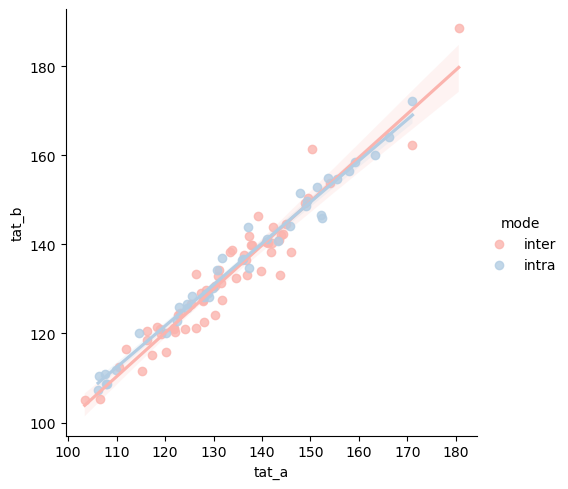

In [12]:
import seaborn as sns
sns.set_palette('Pastel1')
sns.lmplot(data=df_lat, x='tat_a', y='tat_b', hue='mode') 

tat_a = df_lat['tat_a']
tat_a_inter = tat_a[df_lat['mode'] == 'inter']
tat_a_intra = tat_a[df_lat['mode'] == 'intra']

tat_b = df_lat['tat_b']
tat_b_inter = tat_b[df_lat['mode'] == 'inter']
tat_b_intra = tat_b[df_lat['mode'] == 'intra']

print(iou.get_boxplot_values(tat_a_inter))
print(iou.get_boxplot_values(tat_b_inter))

print(iou.get_boxplot_values(tat_a_intra))
print(iou.get_boxplot_values(tat_b_intra))


print(sstat.ranksums(tat_a_inter, tat_b_inter))
print(sstat.ranksums(tat_a_intra, tat_b_intra))

print('mean {}, sd {} '.format(
    np.mean(df_lat['correlation'][df_lat['mode']=='inter']),
    np.std(df_lat['correlation'][df_lat['mode']=='inter'])
    ))
print('mean {}, sd {} '.format(
    np.mean(df_lat['correlation'][df_lat['mode']=='intra']),
    np.std(df_lat['correlation'][df_lat['mode']=='intra'])
    ))

# df_lat.iloc[df_lat[df_lat['corr_p_val']>0].index]
print('inter')
print(iou.get_boxplot_values(df_lat['abs_diff'][df_lat['mode']=='inter']))
print('intra')
print(iou.get_boxplot_values(df_lat['abs_diff'][df_lat['mode']=='intra']))


<AxesSubplot:xlabel='mode', ylabel='correlation'>

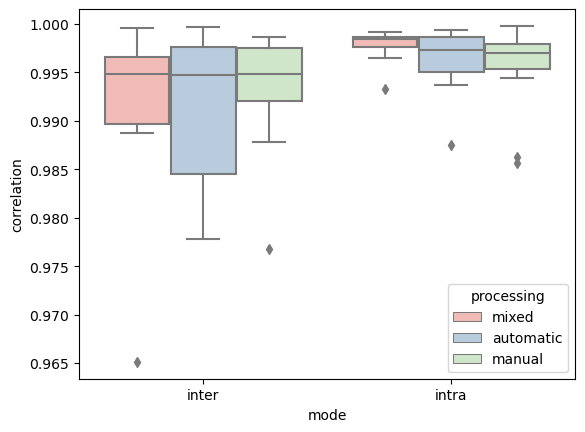

In [16]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# sm.graphics.mean_diff_plot(df_lat['tat_a'], df_lat['tat_b'])
sns.set_palette('Pastel1')
sns.boxplot(data=df_lat, x='mode', y='correlation', hue='processing')


### CV Comparisons
1. Get boxplot quartiles per observation
2. Include 
3. Build table 
   
|     | Corr (p-val) | A: median (+/- IQR) | B: median (+/- IQR) | ranksum p-val | mode  | processing |    fibre   |
|-----|--------------|---------------------|---------------------|---------------|-------|------------|------------|
| C0  | corr (p)     | m (+/- IQR)         | m (+/- IQR)         | p             | inter | mixed      |      1     |
| C0  | corr (p)     | m (+/- IQR)         | m (+/- IQR)         | p             | inter | mixed      |      l     |
| ... | ...          | ...                 | ...                 | ...           | ...   | ...        |     ...    |
| C30 | corr (p)     | m (+/- IQR)         | m (+/- IQR)         | p             | intra | automatic  |      1     |
| ... | ...          | ...                 | ...                 | ...           | ...   | ...        |     ...    |

In [13]:
import scipy.stats as sstat

dx = 'gradlat'
fibre_files = ['1', 'l']
keys = ['correlation', 'corr_p_val', 'median_a', 'iqr_a',
        'median_b', 'iqr_b', 'ranksum_p_val', 
        'mode', 'processing', 'fibre']
midic = dict.fromkeys(keys)

midic['correlation'] = np.zeros(len(CX)*2)
midic['corr_p_val'] = np.zeros(len(CX)*2)
midic['median_a'] = np.zeros(len(CX)*2)
midic['iqr_a'] = np.zeros(len(CX)*2)
midic['median_b'] = np.zeros(len(CX)*2)
midic['iqr_b'] = np.zeros(len(CX)*2)
midic['ranksum_p_val'] = np.zeros(len(CX)*2)
midic['mean_a'] = np.zeros(len(CX)*2)
midic['std_a'] = np.zeros(len(CX)*2)
midic['mean_b'] = np.zeros(len(CX)*2)
midic['std_b'] = np.zeros(len(CX)*2)
midic['ttest_p_val'] = np.zeros(len(CX)*2)
midic['fibre'] = ['1', 'l']*50
midic['mode'] = df_comp['mode'].tolist()
midic['processing'] = np.repeat(processing, 2)


for cx in range(len(CX)):
    for fx in range(len(fibre_files)):

        comparison_file = iou.fullfile(
            comp_dir, CX[cx], 'COMPARISONS', cname(dx, fibre_files[fx]))
        df = pd.read_csv(comparison_file, skipinitialspace=True).sample(frac=subsample).reset_index()
        A = 1/df[dx+'_0']
        B = 1/df[dx+'_1']

        ix_a = A[A < iou.get_boxplot_values(A)['low_whisker']].index
        ix_b = B[B < iou.get_boxplot_values(B)['low_whisker']].index

        drop_indx = np.unique(ix_a.append(ix_b))

        A = 1/A.drop(drop_indx)
        B = 1/B.drop(drop_indx)

        ss = sstat.pearsonr(x=A, y=B)

        quarts_a = iou.get_boxplot_values(A)
        quarts_b = iou.get_boxplot_values(B)

        idx = 2*cx + fx

        midic['correlation'][idx] = ss.statistic
        midic['corr_p_val'][idx] = ss.pvalue

        midic['median_a'][idx] = quarts_a['median']
        midic['iqr_a'][idx] = quarts_a['high_quartile'] - quarts_a['low_quartile']
        midic['median_b'][idx] = quarts_b['median']
        midic['iqr_b'][idx] = quarts_b['high_quartile'] - quarts_b['low_quartile']
        midic['ranksum_p_val'][idx] = sstat.ranksums(A, B).pvalue

        midic['mean_a'][idx] = np.mean(A)
        midic['std_a'][idx] = np.std(A)
        midic['mean_b'][idx] = np.mean(B)
        midic['std_b'][idx] = np.std(B)
        midic['ttest_p_val'][idx] = sstat.ttest_ind(A,B).pvalue

df_cv = pd.DataFrame(midic)
df_cv 

,correlation,corr_p_val,median_a,iqr_a,median_b,iqr_b,ranksum_p_val,mode,processing,fibre,mean_a,std_a,mean_b,std_b,ttest_p_val
0,0.097933,0.000000e+00,786.850160,264.215420,816.133324,290.354827,9.139831e-122,inter,mixed,1,798.727866,185.635188,805.112285,185.530099,1.376709e-35
1,-0.048259,9.623675e-135,672.375132,239.943704,804.929388,329.143698,0.000000e+00,inter,mixed,l,716.803810,186.387278,792.628567,209.736057,0.000000e+00
2,0.624555,0.000000e+00,813.576973,273.431193,806.373577,271.993473,8.946379e-22,inter,automatic,1,816.720042,190.097324,809.896010,180.534704,1.945806e-38
3,0.707462,0.000000e+00,740.938324,273.368676,730.983465,259.593937,7.170594e-04,inter,automatic,l,761.857877,197.390267,756.537819,180.605341,3.991035e-23
4,0.699186,0.000000e+00,809.523231,269.497036,814.352142,265.002027,2.986355e-08,inter,automatic,1,814.579453,185.836907,814.492831,174.734514,8.589772e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.474940,0.000000e+00,718.716086,273.374863,715.753008,264.373049,7.187529e-06,intra,automatic,l,747.997330,185.963794,746.713459,176.008764,3.175305e-03
96,0.530190,0.000000e+00,798.849656,256.799932,795.544948,254.560616,3.122076e-05,intra,automatic,1,805.834931,181.273914,803.489867,178.336323,8.360039e-06
97,0.738843,0.000000e+00,740.236283,269.856206,726.754749,254.357016,6.967231e-86,intra,automatic,l,757.441058,186.721074,746.838035,178.763274,1.485607e-87
98,0.501290,0.000000e+00,814.358774,281.628991,811.405110,272.817683,6.726695e-03,intra,mixed,1,817.896481,193.698199,815.360182,186.505392,5.752807e-06


Ttest_indResult(statistic=-0.6176239927707987, pvalue=0.5380133272907413)
mean 775.5608208327578, sd 37.668539057243436 
mean 781.7926147986461, sd 31.158368314146863 
Ttest_indResult(statistic=0.29085752111204716, pvalue=0.7719322790893955)
mean 779.6042036789361, sd 33.313038605923566 
mean 779.6971229373929, sd 32.45706661415818 
differences
mean -4.043382846177809, sd 15.468827930991152 
mean 2.095491861253174, sd 11.544522387476711 


Int64Index([4, 5, 35, 38, 50, 64, 65, 68, 78, 84], dtype='int64')

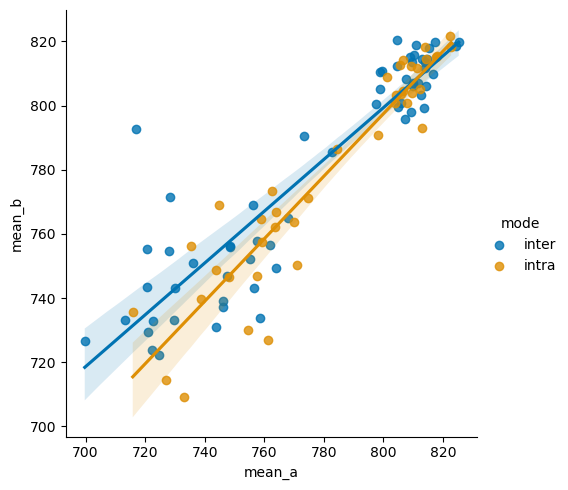

In [16]:
sns.set_palette('colorblind')
sns.lmplot(data=df_cv, x='mean_a', y='mean_b', hue='mode')

print(sstat.ttest_ind(df_cv['mean_a'][df_cv['mode'] == 'inter'], df_cv['mean_b'][df_cv['mode'] == 'inter']))
print('mean {}, sd {} '.format(
    np.mean(df_cv['mean_a'][df_cv['mode'] == 'inter']),
    np.std(df_cv['mean_a'][df_cv['mode'] == 'inter'])
))
print('mean {}, sd {} '.format(
    np.mean(df_cv['mean_a'][df_cv['mode'] == 'intra']),
    np.std(df_cv['mean_a'][df_cv['mode'] == 'intra'])
))

print(sstat.ttest_ind(df_cv['mean_a'][df_cv['mode'] == 'intra'], df_cv['mean_b'][df_cv['mode'] == 'intra']))
print('mean {}, sd {} '.format(
    np.mean(df_cv['mean_b'][df_cv['mode'] == 'inter']),
    np.std(df_cv['mean_b'][df_cv['mode'] == 'inter'])
))
print('mean {}, sd {} '.format(
    np.mean(df_cv['mean_b'][df_cv['mode'] == 'intra']),
    np.std(df_cv['mean_b'][df_cv['mode'] == 'intra'])
))

print('differences')
print('mean {}, sd {} '.format(
    np.mean(df_cv['mean_a'][df_cv['mode'] == 'inter'] - df_cv['mean_b'][df_cv['mode'] == 'inter']),
    np.std(df_cv['mean_a'][df_cv['mode'] == 'inter'] - df_cv['mean_b'][df_cv['mode'] == 'inter'])
))
print('mean {}, sd {} '.format(
    np.mean(df_cv['mean_a'][df_cv['mode'] == 'intra'] -
            df_cv['mean_b'][df_cv['mode'] == 'intra']),
    np.std(df_cv['mean_a'][df_cv['mode'] == 'intra'] -
           df_cv['mean_b'][df_cv['mode'] == 'intra'])
))

(df_cv['ttest_p_val'][df_cv['ttest_p_val']>0.05].index)



### PS comparisons
Compare Correlation and Structural similarity index (SSIM)

In [40]:
from skimage.metrics import structural_similarity as ssim

def cname(dx, mx):
    return dx + '_' + mx + '.csv'

dx = 'ps'
fibre_files = ['1', 'l']

keys = ['correlation', 'corr_p_val', 'ssim',  
        'mode', 'processing', 'fibre']
midic = dict.fromkeys(keys)

midic['correlation'] = np.zeros(len(CX)*2)
midic['corr_p_val'] = np.zeros(len(CX)*2)
midic['ssim'] = np.zeros(len(CX)*2)
midic['fibre'] = ['1', 'l']*50
midic['mode'] = df_comp['mode'].tolist()
midic['processing'] = np.repeat(processing, 2)

for cx in range(len(CX)):
    for fx in range(len(fibre_files)):

        comparison_file = iou.fullfile(comp_dir, CX[cx], 'COMPARISONS', cname(dx, fibre_files[fx]))
        df = pd.read_csv(comparison_file, skipinitialspace=True).sample(
            frac=subsample).reset_index()
        ss = ssim(df[dx+'_0'], df[dx+'_1'])
        cc = sstat.pearsonr(df[dx+'_0'], df[dx+'_1'])

        idx = 2*cx + fx

        midic['correlation'][idx] = cc.statistic
        midic['corr_p_val'][idx] = cc.pvalue
        midic['ssim'][idx] = ss


df_ps = pd.DataFrame(midic)
df_ps    


# ssim()

/home/jsl19/anaconda3/envs/imatools/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/jsl19/anaconda3/envs/imatools/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,correlation,corr_p_val,ssim,mode,processing,fibre
0,0.020221,2.328425e-13,0.301790,inter,mixed,1
1,0.020221,2.328425e-13,0.301988,inter,mixed,l
2,0.318511,0.000000e+00,0.729963,inter,automatic,1
3,0.318511,0.000000e+00,0.730929,inter,automatic,l
4,0.507592,0.000000e+00,0.912228,inter,automatic,1
...,...,...,...,...,...,...
95,0.008491,4.038580e-04,0.458770,intra,automatic,l
96,0.752437,0.000000e+00,0.773126,intra,automatic,1
97,0.752437,0.000000e+00,0.771703,intra,automatic,l
98,0.155789,0.000000e+00,0.681035,intra,mixed,1


In [31]:
print('INTER')
print('mean {}, sd {} '.format(
    np.mean(df_ps['correlation'][df_ps['mode'] == 'inter']),
    np.std(df_ps['correlation'][df_ps['mode'] == 'inter'])
))
print('mean {}, sd {} '.format(
    np.mean(df_ps['ssim'][df_ps['mode'] == 'inter']),
    np.std(df_ps['ssim'][df_ps['mode'] == 'inter'])
))

print('INTRA')
print('mean {}, sd {} '.format(
    np.mean(df_ps['correlation'][df_ps['mode'] == 'intra']),
    np.std(df_ps['correlation'][df_ps['mode'] == 'intra'])
))
print('mean {}, sd {} '.format(
    np.mean(df_ps['ssim'][df_ps['mode'] == 'intra']),
    np.std(df_ps['ssim'][df_ps['mode'] == 'intra'])
))

df_ps['corr_p_val'][df_ps['corr_p_val']>0.05].index

df_ps.iloc[[6,7]]


INTER
mean 0.3054641775142144, sd 0.2548505497765108 
mean 0.6484299936869888, sd 0.21124522891371741 
INTRA
mean 0.24844573732096661, sd 0.18875476194022706 
mean 0.6083503245185107, sd 0.15158631652721122 


,correlation,corr_p_val,ssim,mode,processing,fibre
6,-0.00431,0.218895,0.461653,inter,automatic,1
7,-0.00479,0.171854,0.461839,inter,automatic,l


### LAT/CV visualisations 
|            | Observation A | Observation B | Comparison together | CV histograms              |
|------------|---------------|---------------|---------------------|----------------------------|
| Intra (X)  | Map A         | Map B         | Map - Both          | overlapped histogram (A/B) |
| Intra (Y)  | Map A         | Map B         | Map - Both          | overlapped hist            |
| Inter (X)  | ...           | ...           | ...                 | ...                        |
| Inter (Y)  | ...           | ...           | ...                 | ...                        |

1. Get mapping file
2. Create vtk files for A, B observations using Mapping information
3. Create 10 thresholds per case 
4. Create images 
   1. Manually on paraview, or 
   2. automatically (`vtkContourFilter`) 
> then, for the last column try 
5. Load CV for both cases 
6. use `sns.histplot()` to create overlapping histogram representations, could be 2D histogram
7. Assemble in graphic 

In [66]:
import vtk.util.numpy_support as vtknp 

vis_dir = iou.fullfile(base_dir, '012_visualisations')
m = 'INTRA' 
x = ['0', '1']
lat = 'LAT_RSPV_1.dat'
vtk_name = 'fibre_1_endo.vtk'

vis_comp_dir = iou.fullfile(vis_dir, m + x[1])

df_map = pd.read_csv(iou.fullfile(vis_comp_dir, 'MAPPING', 'fibre_1_pts.csv'), index_col=0)
n=len(df_map)

df_map = df_map.drop(np.arange(start=int(n/2), stop=n)).reset_index()
obs_a = df_map.columns[0]
obs_b = df_map.columns[1]

lat_full_a = np.loadtxt(iou.fullfile(vis_comp_dir,obs_a, lat))
lat_full_b = np.loadtxt(iou.fullfile(vis_comp_dir,obs_b, lat))

lat_a = lat_full_a[df_map[obs_a].tolist()]
lat_b = lat_full_b[df_map[obs_b].tolist()]

msh_a = vtku.readVtk(iou.fullfile(vis_comp_dir, obs_a, vtk_name))
msh_b = vtku.readVtk(iou.fullfile(vis_comp_dir, obs_b, vtk_name))

msh_a.GetPointData().SetScalars(vtknp.numpy_to_vtk(lat_a))
msh_b.GetPointData().SetScalars(vtknp.numpy_to_vtk(lat_b))

vtku.writeVtk(msh_a, vis_comp_dir, obs_a)
vtku.writeVtk(msh_b, vis_comp_dir, obs_b)


In [105]:
import vtk.util.numpy_support as vtknp

def attach_scalars_to_vtk(vtk_name, lat_name, ishalf=True) : 
    lat_full = np.loadtxt(lat_name)
    div_num = 2 if ishalf else 1 
    n = int(len(lat_full)/div_num)

    lat = lat_full[0:(n-1)]
    
    msh = vtku.readVtk(vtk_name)
    msh.GetPointData().SetScalars(vtknp.numpy_to_vtk(lat))

    return msh, lat 

save_output = False

vis_dir = iou.fullfile(base_dir, '012_visualisations')
modes = ['INTRA', 'INTER']
ex = ['0', '1']
_a = 'A'
_b = 'B'

cv = 'lat_1.gradmag.dat'
lat = 'LAT_RSPV_1.dat'
vtk_name = 'fibre_1_endo.vtk'

mx = 1
x  = 0

vis_comp_dir = iou.fullfile(vis_dir, modes[mx] + ex[x])

obs_a = iou.fullfile(vis_comp_dir, _a) 
obs_b = iou.fullfile(vis_comp_dir, _b) 

msh_a, lat_a = attach_scalars_to_vtk(iou.fullfile(obs_a, vtk_name), iou.fullfile(obs_a, lat))
msh_b, lat_b = attach_scalars_to_vtk(iou.fullfile(obs_b, vtk_name), iou.fullfile(obs_b, lat))

if save_output : 
    vtku.writeVtk(msh_a, vis_comp_dir, _a)
    vtku.writeVtk(msh_b, vis_comp_dir, _b)

print(modes[mx] + ex[x])
print('_a')
print(np.linspace(np.min(lat_a), np.max(lat_a), 11))
print('_b')
print(np.linspace(np.min(lat_b), np.max(lat_b), 11))


INTER0
_a
[ 11.0468   22.73562  34.42444  46.11326  57.80208  69.4909   81.17972
  92.86854 104.55736 116.24618 127.935  ]
_b
[ 11.1229   22.78421  34.44552  46.10683  57.76814  69.42945  81.09076
  92.75207 104.41338 116.07469 127.736  ]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


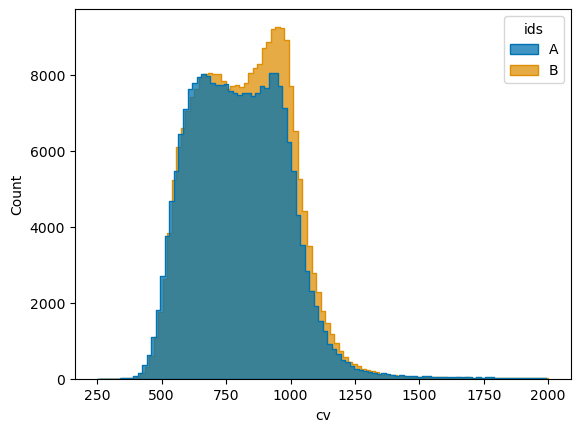

In [106]:
import matplotlib.pyplot as plt
rm_extremes = False 

gradlat_a = np.loadtxt(iou.fullfile(obs_a, cv))
gradlat_b = np.loadtxt(iou.fullfile(obs_b, cv))
bpv_a = iou.get_boxplot_values(gradlat_a)
bpv_b = iou.get_boxplot_values(gradlat_b)

grdlt_a = gradlat_a[gradlat_a >= bpv_a['low_whisker']] if rm_extremes else gradlat_a
grdlt_b = gradlat_b[gradlat_b >= bpv_b['low_whisker']] if rm_extremes else gradlat_b

cv_a = 1/grdlt_a
cv_b = 1/grdlt_b

cvs = cv_a.tolist() + cv_b.tolist()
ids = [_a]*len(cv_a) + [_b]*len(cv_b)

df_vis_cv = pd.DataFrame({'cv' : cvs, 'ids': ids})

# sns.set_palette('colorblind')
sns.histplot(data=df_vis_cv, x='cv', hue='ids', element='step', bins=100, multiple='dodge', binrange=(250, 2000), stat='count')
plt.savefig(iou.fullfile(vis_comp_dir, 'hist.eps'))

In [88]:
help(sns.histplot)

Help on function histplot in module seaborn.distributions:

histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)
    Plot univariate or bivariate histograms to show distributions of datasets.
    
    A histogram is a classic visualization tool that represents the distribution
    of one or more variables by counting the number of observations that fall within
    disrete bins.
    
    This function can normalize the statistic computed within each bin to estimate
    frequency, density or probability mass, and it can add a smooth curve obtained
    using a kernel density estimate,

<AxesSubplot:xlabel='cv', ylabel='Count'>

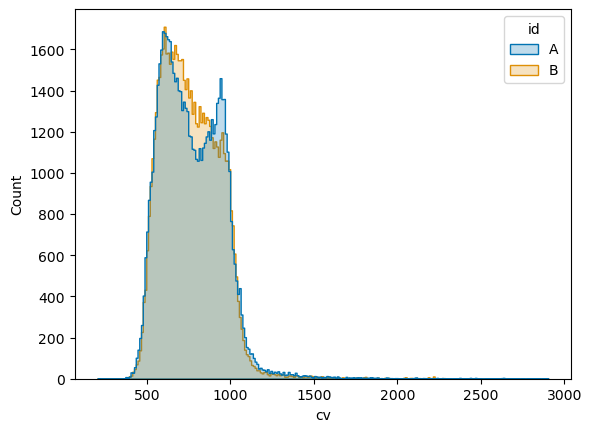

In [56]:
cvs = A.tolist() + B.tolist()
ids = ['A']*len(A) + ['B']*len(B)

df_vis_cv = pd.DataFrame({'cv' : cvs, 'id' : ids})
df_vis_cv

sns.histplot(data=df_vis_cv, x='cv', hue='id', element='step')
